### Se importan las librerías

In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_xml(file):
    root = et.parse(file).getroot()
    worksheet = root[2]
    
    ncols = sum([1 for j in worksheet[0][0] for i in j])
    values =[[i.text for j in worksheet[0] for i in j[n]]for n in range(ncols)]
    
    opt = pd.DataFrame(values).transpose()
    opt.columns = opt.iloc[0]
    opt = opt.drop([0]).apply(pd.to_numeric)
    
    return opt

In [3]:
opt = read_xml("ReportOptimizer7.xml")

In [4]:
opt.head()

,Pass,Result,Profit,Expected Payoff,Profit Factor,Recovery Factor,Sharpe Ratio,Custom,Equity DD %,Trades,period1,period2
1,60,19420.0,9420.0,15.096154,1.848649,1.787476,0.235950,0,32.0384,624,21,57
2,98,18059.0,8059.0,62.960938,7.858723,4.530073,0.877572,0,16.0719,128,29,60
3,99,17909.0,7909.0,59.022388,6.969057,4.473416,0.796284,0,16.1550,134,30,60
4,45,17574.0,7574.0,15.746362,1.891059,1.961160,0.231853,0,26.2793,481,26,55
5,19,17564.0,7564.0,19.005025,2.112353,1.973904,0.261468,0,21.1701,398,30,52


In [5]:
len(opt)

100

In [6]:
opt["ibalance"] = ((opt["Result"]/(opt["Result"]-opt["Profit"]))-1)/(opt["Equity DD %"]/100)
index = np.sort(opt["period1"].unique())
cols = np.sort(opt["period2"].unique())

In [7]:
index

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [8]:
cols

array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

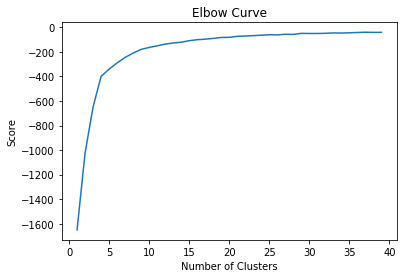

In [9]:
x = opt[["period1","period2"]]
y = opt["ibalance"]
Nc = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [10]:
n = 5
kmeans = KMeans(n_clusters=n).fit(x)
centroids = kmeans.cluster_centers_
clusters = kmeans.predict(x)
x["Clusters"] = clusters

#%%
grupos = [x.loc[x["Clusters"] == i] for i in range(n)]
grupos = [i.join(y) for i in grupos]

In [11]:
grupos[0]

,period1,period2,Clusters,ibalance
5,30,52,0,3.572964
7,29,53,0,3.155059
8,29,52,0,3.409702
10,30,51,0,3.182564
11,28,54,0,2.942097
18,28,53,0,2.876317
20,27,52,0,2.225555
25,27,51,0,1.310085
26,30,53,0,1.849824
27,26,52,0,1.330628


In [12]:
grupos[1]

,period1,period2,Clusters,ibalance
1,21,57,1,2.940222
13,22,57,1,2.757565
16,23,56,1,2.728061
17,22,56,1,1.868677
21,24,59,1,1.596497
23,21,56,1,1.806668
30,24,60,1,2.042386
36,22,59,1,1.517564
39,21,59,1,1.638114
41,23,58,1,1.507296


In [13]:
top = [i.nlargest(1,"ibalance") for i in grupos]
top = pd.concat(top)
top.index = top["Clusters"]
top = top.drop(["Clusters"],axis=1)

In [14]:
top

,period1,period2,ibalance
Clusters,,,
0,30,52,3.572964
1,21,57,2.940222
2,29,60,5.014342
3,24,51,1.474374
4,26,55,2.882116


### Se obtienen las matrizes a utilizar

In [15]:
matrix,ntrades,mclusters = [pd.DataFrame(np.zeros([len(index),len(cols)]),index=index,columns=cols) for i in range(3)]
gruposconc = pd.concat(grupos)

for i in range(len(opt)):
    for y in index:
        for x in cols:
            if opt.iloc[i,-3] == y and x == opt.iloc[i,-2]:
                matrix.loc[[y],[x]] = opt.iloc[i,-1]
                ntrades.loc[[y],[x]] = opt.iloc[i,-4]
            elif gruposconc.iloc[i,0] == y and x == gruposconc.iloc[i,1]:
                mclusters.loc[[y],[x]] = gruposconc.iloc[i,2]

### Se gráfican los resultados para mejor visualización

In [16]:
import plotly.io as pio
pio.renderers.default = "browser"

fig = make_subplots(rows=1, cols=1,
                    specs=[[{'is_3d': True}]],
                    subplot_titles='Numero de operaciones')
fig.add_trace(go.Surface(x=matrix.columns,y=matrix.index,z=matrix,surfacecolor=mclusters,colorbar_x=-0.07), 1, 1)
# fig.add_trace(go.Surface(x=matrix.columns,y=matrix.index,z=matrix,surfacecolor=ntrades), 1, 2)
fig.update_layout(title_text="Gráficas")

In [17]:
# pip install chart_studio --user